In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
cell_genotypes = pd.read_csv('./10nodes_40regions_10000reads_sim_tiny2_ground_truth.txt', sep=' ' ,header=None)

In [3]:
cell_genotypes = cell_genotypes[cell_genotypes.columns[:-1]]

In [4]:
cell_genotypes.head()

,0,1,2,3,4,5,6,7,8,9,...,989,990,991,992,993,994,995,996,997,998
0,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
1,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
2,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
3,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
4,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2


In [5]:
cell_bps = cell_genotypes.diff(periods=1, axis=1)
cell_bps.head()

,0,1,2,3,4,5,6,7,8,9,...,989,990,991,992,993,994,995,996,997,998
0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
cell_bps = cell_bps.fillna(value=0.0)
cell_bps.head()

,0,1,2,3,4,5,6,7,8,9,...,989,990,991,992,993,994,995,996,997,998
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
cell_bps[cell_bps != 0] = 1 # replace the non-zeroes by 1

In [8]:
grouped_cell_bps = cell_bps.sum(axis=0)

In [9]:
ground_truth = grouped_cell_bps[grouped_cell_bps > 0]
ground_truth

178     7.0
191     7.0
201     2.0
219     2.0
322     7.0
339     7.0
545     4.0
584     4.0
678    11.0
707    15.0
751     4.0
797    13.0
818    13.0
861     3.0
873    11.0
919    21.0
934    13.0
dtype: float64

In [10]:
ground_truth = ground_truth.index.tolist()

In [11]:
bps = pd.read_csv('./simdata_all_bps_comparison.csv', header=None)

In [12]:
bps.columns = ['idx','log_sp','stdev']

In [13]:
bps.shape

(58, 3)

In [14]:
bps.index = bps['idx']

In [15]:
n_bins = 1000
all_bins = range(0,n_bins)

In [16]:
all_bins_df = pd.DataFrame(index=all_bins)
all_bins_df['idx'] = all_bins_df.index
all_bins_df['log_sp'] = None
all_bins_df['stdev'] = None

In [17]:
all_bins_df.head()

,idx,log_sp,stdev
0,0,None,None
1,1,None,None
2,2,None,None
3,3,None,None
4,4,None,None


#### correcting for the bps 1-2 bins nearby

In [18]:
for index, row in bps.iterrows():
    idx_val = bps.loc[index, 'idx']
    for gt in ground_truth:
        if (abs(idx_val - gt) <=2 and idx_val != gt):
            print('correcting ' + str(idx_val) + '->' + str(gt))
            bps.loc[index,'idx'] = gt

correcting 583->584


In [19]:
bps.head()

,idx,log_sp,stdev
idx,,,
818,818,2.57653,0.304358
797,797,2.26655,0.277304
919,919,2.12216,0.256878
934,934,1.81849,0.226695
191,191,1.62914,0.202606


In [31]:
bps.shape

(58, 4)

In [30]:
Counter((1.5*bps['log_sp'] - bps['stdev']).values > 0)

Counter({True: 58})

In [29]:
Counter((1.5*bps['log_sp'] - bps['stdev']).values < 0)

Counter({False: 58})

### ROC curve
Each breakpoint candidate has a different stdev value. The ROC computations should take that into account.

In [20]:
bps['ranking'] = bps['log_sp'] / bps['stdev']

In [21]:
bps = bps.dropna()

In [22]:
threshold_coeffs = sorted(bps['ranking'].values)

In [23]:
tpr_values = []
fpr_values = []
for thr in threshold_coeffs:
    positives = []
    negatives = []
    # import ipdb; ipdb.set_trace() # debugging starts here
    for index, row in bps.iterrows():
        if row['ranking'] > thr:
            positives.append(row['idx'])
        else:
            break 
    negatives = [i for i in bps['idx'].values.tolist() if i not in positives]
    
    # positives = bps[(thr > bps['ranking'])]['idx'].values.tolist()
    # negatives = bps[(thr <= bps['ranking'])]['idx'].values.tolist()

    true_positives = [i for i in positives if i in ground_truth]
    false_positives = [i for i in positives if i not in true_positives]

    true_negatives = [i for i in negatives if i not in ground_truth]
    false_negatives = [i for i in negatives if i in ground_truth]

    tpr = len(true_positives) / (len(true_positives) + len(false_negatives))
    fpr = len(false_positives) / (len(false_positives) + len(true_negatives))
    tpr_values.append(tpr)
    fpr_values.append(fpr)

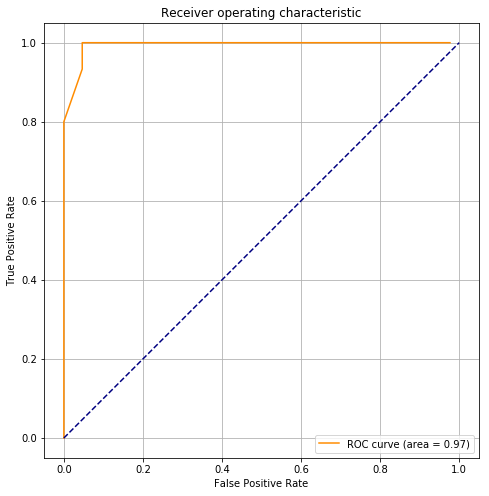

In [24]:
roc_auc = auc(fpr_values, tpr_values)
plt.figure(figsize=(8,8))
plt.plot(fpr_values, tpr_values, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()